In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mwclient

from lol_fandom import SITE
from lol_fandom import get_leagues, get_tournaments
from lol_fandom import get_scoreboard_games, get_scoreboard_players
from lol_fandom import from_response

from google_sheet import Sheet

pd.set_option('display.max_columns', None)

with open('./sheet_id.txt', 'r') as f:
    SHEET_ID = f.read()

In [2]:
sheet = Sheet(SHEET_ID)
sheet.connect_sheet()

In [3]:
class Team:
    K = 20
    leagues_r = {
        'LCK': 1000,
        'LPL': 1000,
        'LEC': 950,
        'LCS': 900,
        'PCS': 850,
        'VCS': 850,
        'LJL': 800,
        'CBLOL': 800,
        'LLA': 800,
        'LCO': 800,
        'TCL': 800,
        'LCL': 800,
    }

    def __init__(self, name, league):
        self.name = name
        self.league = league
        self.win = 0
        self.loss = 0
        self.point = 1000
        self.point = self.leagues_r[league]
        self.points = [self.point]

    def update_point(team1, team2, result):
        # result: team1 win 1, team1 loss 0
        assert isinstance(team1, Team)
        assert isinstance(team2, Team)

        team1_wr = team1.get_win_prob(team2)
        team2_wr = team2.get_win_prob(team1)
        team1._update_point(team1_wr, result)
        team2._update_point(team2_wr, 1 - result)

    def get_win_prob(self, opponent):
        assert isinstance(opponent, Team)

        return 1 / (10 ** ((opponent.point - self.point) / 400) + 1)

    def _update_point(self, winrate, result):
        # result: win 1, loss 0
        assert result == 0 or result == 1

        if result == 1:
            self.win += 1
        else:
            self.loss += 1

        self.point = self.point + self.K * (result - winrate)
        self.points.append(self.point)

    def to_dict(self):
        data = {
            'League': self.league,
            'Win': self.win,
            'Loss': self.loss,
            'WinRate': self.win / (self.win + self.loss) if self.win != 0 else 0,
            'Point': self.point
        }

        return data

    def to_dataframe(self):
        df = pd.DataFrame({
            'name': [self.name] * len(self.points), 'point': self.points
        })
        return df

In [4]:
def proceed_rating(teams, games):
    for row in games.itertuples():
        team1, team2 = row.Team1, row.Team2
        result = 1 if row.WinTeam == team1 else 0
        Team.update_point(teams[team1], teams[team2], result)

def get_rating(teams):
    ratings = pd.DataFrame(
        data=map(lambda x: x.to_dict(), teams.values()),
        index=teams.keys()
    )
    ratings = ratings.sort_values(by='Point', ascending=False)
    return ratings

def get_team_name(same_team_names, name):
    while name in same_team_names:
        name = same_team_names[name]
    return name

In [5]:
leagues = get_leagues()
leagues

,League,League Short,Region,Level,IsOfficial
0,2015 All-Star Event,2015 ASE,International,Showmatch,Yes
1,2015 International Wildcard Tournament,2015 IWCT,International,Primary,Yes
2,2016 International Wildcard Qualifier,IWCQ,International,Primary,Yes
3,All-Star,All-Star,International,Showmatch,Yes
4,Arena of Legends,AOL,North America,Secondary,No
...,...,...,...,...,...
120,Vietnam Championship Series,VCS,Vietnam,Primary,Yes
121,Volcano League,VL,Latin America,Secondary,Yes
122,World Championship,WCS,International,Primary,Yes
123,World Cyber Arena,WCA,China,Primary,No


In [6]:
target_leagues = [
    'LCK', 'LPL', 'LEC', 'LCS', 'MSI', 'WCS',
    'PCS', 'VCS', 'LJL', 'CBLOL', 'LLA', 'LCO', 'TCL', 'LCL',
]

In [7]:
tournaments = pd.DataFrame()
for league in target_leagues:
# for league in ['LCL']:
    t = get_tournaments(f'L.League_Short="{league}" and T.Year in (2022)')
    tournaments = pd.concat([tournaments, t])
tournaments = tournaments.sort_values(by=['Year', 'DateStart', 'Date']).reset_index(drop=True)
tournaments

,Name,OverviewPage,DateStart,Date,League,Region,EventType,StandardName,Split,SplitNumber,TournamentLevel,IsQualifier,IsPlayoffs,IsOfficial,Year,DateStart__precision,Date__precision
0,LLA 2022 Opening Promotion,LLA/2022 Season/Opening Promotion,2021-09-01,2021-09-05,Liga Latinoamerica,Latin America,Offline,LLA 2022 Opening Promotion,Opening,1,Primary,1,0,1,2022,1,1
1,LPL 2022 Spring,LPL/2022 Season/Spring Season,2022-01-10,2022-03-25,Tencent LoL Pro League,China,Offline/Online,LPL 2022 Spring,Spring,1,Primary,0,0,1,2022,1,1
2,LCK 2022 Spring,LCK/2022 Season/Spring Season,2022-01-12,2022-03-20,LoL Champions Korea,Korea,Offline,LCK 2022 Spring,Spring,1,Primary,0,0,1,2022,1,1
3,LCS 2022 Lock In,LCS/2022 Season/Lock In,2022-01-14,2022-01-30,League of Legends Championship Series,North America,None,LCS 2022 Lock In,Spring,1,Primary,0,1,1,2022,1,1
4,LEC 2022 Spring,LEC/2022 Season/Spring Season,2022-01-14,2022-03-06,LoL European Championship,Europe,Online,LEC 2022 Spring,Spring,1,Primary,0,0,1,2022,1,1
5,CBLOL 2022 Split 1,CBLOL/2022 Season/Split 1,2022-01-22,2022-03-20,Circuit Brazilian League of Legends,Brazil,Online,CBLOL 2022 Split 1,Split 1,1,Primary,0,0,1,2022,1,1
6,TCL 2022 Winter,TCL/2022 Season/Winter Season,2022-01-22,2022-03-20,Turkish Championship League,Turkey,Online,TCL 2022 Winter,Winter,1,Primary,0,0,1,2022,1,1
7,LCO 2022 Split 1,LCO/2022 Season/Split 1,2022-01-24,2022-03-22,LoL Circuit Oceania,Oceania,None,LCO 2022 Split 1,Split 1,1,Primary,0,0,1,2022,1,1
8,LLA 2022 Opening,LLA/2022 Season/Opening Season,2022-01-29,2022-03-13,Liga Latinoamerica,Latin America,Online/Offline,LLA 2022 Opening,Opening,1,Primary,0,0,1,2022,1,1
9,LCS 2022 Spring,LCS/2022 Season/Spring Season,2022-02-05,2022-03-27,League of Legends Championship Series,North America,None,LCS 2022 Spring,Spring,1,Primary,0,0,1,2022,1,1


In [8]:
same_team_names = {
    # LCK
    'Afreeca Freecs': 'Kwangdong Freecs',
    # LPL
    'eStar (Chinese Team)': 'Ultra Prime',
    'Rogue Warriors': "Anyone's Legend",
    'Suning': 'Weibo Gaming',
    # PCS
    'Alpha Esports': 'Hurricane Gaming',
    # VCS
    'Percent Esports': 'Burst The Sky Esports',
    'Luxury Esports': 'GMedia Luxury',
    # CBLOL
    'Flamengo Esports': 'Flamengo Los Grandes',
    'Netshoes Miners': 'Miners',
    'Vorax': 'Vorax Liberty',
    'Cruzeiro eSports': 'Netshoes Miners',
    'Vorax Liberty': 'Liberty',
    # LCO
    'Legacy Esports': 'Kanga Esports',
    # TCL
    'SuperMassive Esports': 'SuperMassive Blaze',
}

In [9]:
teams = {}
for page in tournaments['OverviewPage']:
    print(f'{page} rating ...')
    scoreboard_games = get_scoreboard_games(f'T.OverviewPage="{page}"')
    if scoreboard_games is None:
        print(f'{page} is None\n')
        continue
    print(f'{scoreboard_games.shape[0]} games')
    scoreboard_games = scoreboard_games.sort_values(by='DateTime UTC').reset_index(drop=True)

    team_names = scoreboard_games[['Team1', 'Team2']].apply(pd.unique)
    team_names = list(set(list(team_names['Team1']) + list(team_names['Team2'])))
    league = page.split('/')[0]
    new_teams = {}
    for name in team_names:
        new_name = get_team_name(same_team_names, name)
        if name not in teams:
            if name == new_name:
                teams[name] = Team(name, league)
                new_teams[(name,)] = True
            else:
                if new_name not in teams:
                    teams[new_name] = Team(new_name, league)
                    new_teams[(name, new_name)] = True
                teams[name] = teams[new_name]
    if len(new_teams) > 0:
        print(f'There are {len(new_teams)} new teams')
        print(sorted(list(new_teams.keys()), key=lambda x: x[0].lower()))
    print()
    proceed_rating(teams, scoreboard_games)

rating = get_rating(teams)

LLA/2022 Season/Opening Promotion rating ...
25 games
There are 5 new teams
[('Furious Gaming',), ('Globant Emerald',), ('Kaos Latin Gamers',), ('Team Aze',), ('XTEN Esports',)]

LPL/2022 Season/Spring Season rating ...
341 games
There are 17 new teams
[("Anyone's Legend",), ('Bilibili Gaming',), ('EDward Gaming',), ('FunPlus Phoenix',), ('Invictus Gaming',), ('JD Gaming',), ('LGD Gaming',), ('LNG Esports',), ('Oh My God',), ('Rare Atom',), ('Royal Never Give Up',), ('Team WE',), ('ThunderTalk Gaming',), ('Top Esports',), ('Ultra Prime',), ('Victory Five',), ('Weibo Gaming',)]

LCK/2022 Season/Spring Season rating ...
212 games
There are 10 new teams
[('DRX',), ('DWG KIA',), ('Fredit BRION',), ('Gen.G',), ('Hanwha Life Esports',), ('KT Rolster',), ('Kwangdong Freecs',), ('Liiv SANDBOX',), ('Nongshim RedForce',), ('T1',)]

LCS/2022 Season/Lock In rating ...
39 games
There are 10 new teams
[('100 Thieves',), ('Cloud9',), ('Counter Logic Gaming',), ('Dignitas',), ('Evil Geniuses.NA',), ('

In [10]:
team_names = [
    'Gen.G', 'T1', 'DWG KIA', 'DRX', 
    'JD Gaming', 'Top Esports', 'EDward Gaming', 'Royal Never Give Up',
    'G2 Esports', 'Rogue (European Team)', 'Fnatic', 'MAD Lions',
    'Cloud9', '100 Thieves', 'Evil Geniuses.NA',
    'CTBC Flying Oyster', 'GAM Esports',
    'DetonatioN FocusMe', 'LOUD', 'Beyond Gaming', 'Saigon Buffalo', 'Isurus', 'Istanbul Wildcats', 'Chiefs Esports Club'
]

rating.loc[team_names].sort_values(by='Point', ascending=False)

,League,Win,Loss,WinRate,Point
Gen.G,LCK,75,24,0.757576,1245.011290
JD Gaming,LPL,74,36,0.672727,1209.029566
Royal Never Give Up,LPL,99,47,0.678082,1166.667078
Top Esports,LPL,79,46,0.632000,1161.745842
T1,LCK,99,33,0.750000,1159.221838
EDward Gaming,LPL,70,44,0.614035,1136.746194
DWG KIA,LCK,66,42,0.611111,1093.695959
Rogue (European Team),LEC,43,23,0.651515,1092.362487
G2 Esports,LEC,56,30,0.651163,1073.035649
DRX,LCK,60,53,0.530973,1057.176631


In [11]:
team_names = [
    'Gen.G', 'T1', 'DWG KIA', 'DRX', 
    'JD Gaming', 'Top Esports', 'EDward Gaming', 'Royal Never Give Up',
    'G2 Esports', 'Rogue (European Team)', 'Fnatic',
    'Cloud9', '100 Thieves', 'Evil Geniuses.NA',
    'CTBC Flying Oyster', 'GAM Esports'
]

rating.index = rating.index.set_names('Team')
sheet.update_sheet('elo_rating', rating.loc[team_names].sort_values(by='Point', ascending=False))

C:\Users\posky\AppData\Roaming\Python\Python310\site-packages\httplib2\__init__.py:147: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = ssl.SSLContext(DEFAULT_TLS_VERSION)


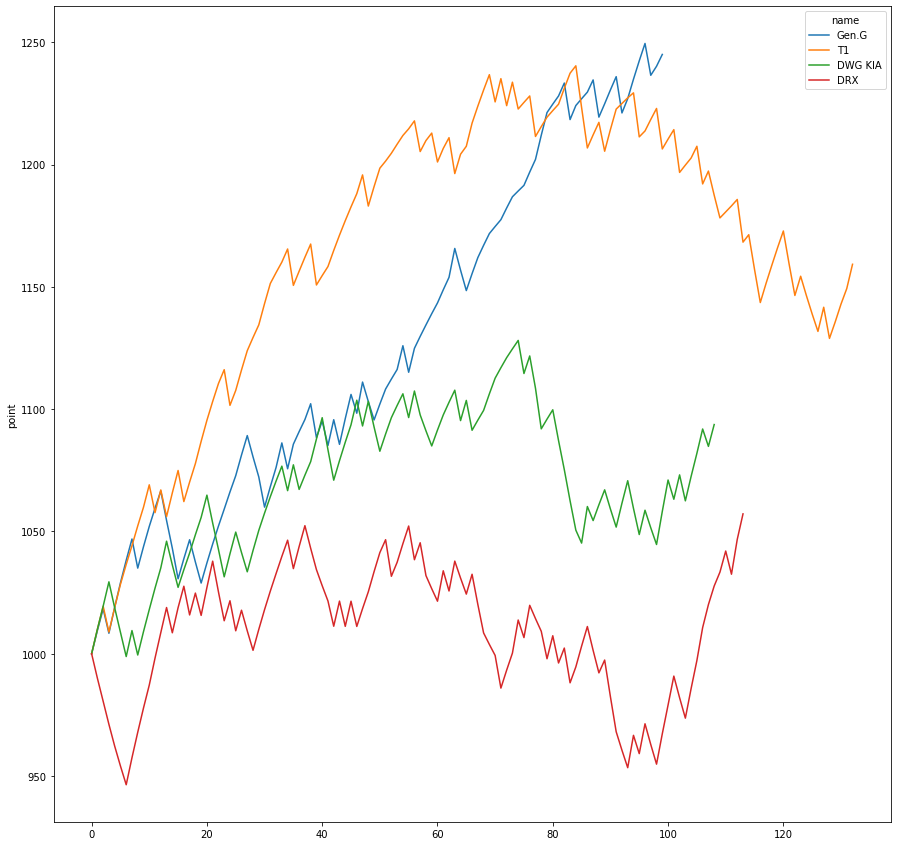

In [17]:
team_names = [
    'Gen.G', 'T1', 'DWG KIA', 'DRX'
]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df = pd.DataFrame()
for name in team_names:
    team = teams[name]
    temp = team.to_dataframe()
    df = pd.concat([df, temp])
sns.lineplot(data=df, x=df.index, y='point', ax=ax, hue='name')
plt.show()